# CS109B - Milestone 2
Authors: Stephanie von Klot-Heydenfeldt, Roberto Vitillo, Alessio Placitelli

In [1]:
import itertools as it
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import pandas as pd
sys.path.append(os.path.realpath('../profondo/store'))

from tmdbw import TMDBW
from imdbw import IMDBW
from pandas.io.json import json_normalize
from skimage.viewer import ImageViewer
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
%matplotlib inline
import operator

C:\Users\Alessio\Anaconda2\lib\site-packages\skimage\viewer\utils\core.py:10: UserWarning: Recommended matplotlib backend is `Agg` for full skimage.viewer functionality.
  warn("Recommended matplotlib backend is `Agg` for full "


## Load the dataset files
As reported in Milestone 1, we built an external library to fetch the data from IMDB and TMDB. We load the dataset here.

In [2]:
TMDB_all =pd.read_pickle("../data/metadata_export_20k")
#TMDB_img = np.load("../data/image_export.npy")

## Data description
After dealing with the preliminary analyses in Milestone 1, we decided to only keep a subset of attributes coming from the TMDB data store. We decided to store the data as two datasets: one containing the movie metadata and one with the poster data.

*The metadata dataset*

- actor1, actor2  - the two main actors of the movie; 
- adult - a flag indicating if this is an adult movie;
- budget - the budget, in USD, used to produce the movie;
- director - the name of the movie director;
- genres - an unsorted list of movie genres
- imdb_id - the IMDB id for the movie, to eventually fetch additional metadata;
- keywords - a list of keywords describing the movie;
- language - the original language of the movie;
- overview - an overview of the movie plot;
- producer1  - the name of the first producer of the movie;
- release_date - the date the movie was released;
- revenue - the revenue of the movie;
- runtime - the runtime of the movie;
- tagline - a catchy phrase for the movie;
- title - the title in the original language;
- tmdb_id - the TMDB id
- writer1 - the name of the first writer for the movie.

*The poster dataset*

- poster - the pixel data for the poster;

The offset of a poster in the poster dataset is the same of the related movie in the metadata dataset.

Even though it was not really required for Milestone 2, we felt the need to address the shortcomings of our EDA analysis from Milestone 1.

### Distribution of categorical features
Create list of variables that can be displayed frequencies

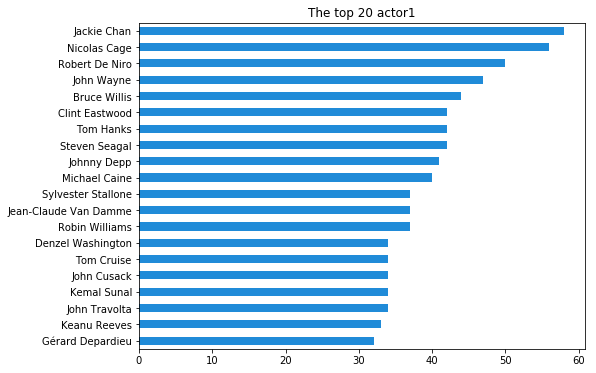

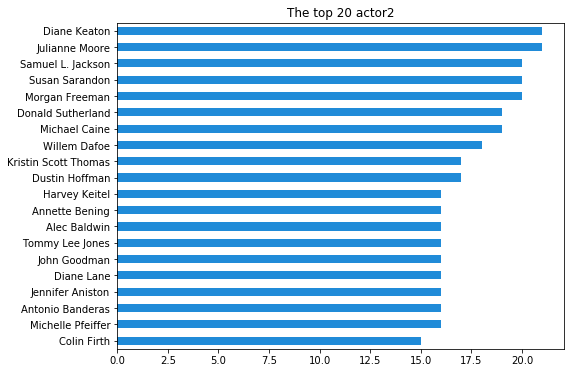

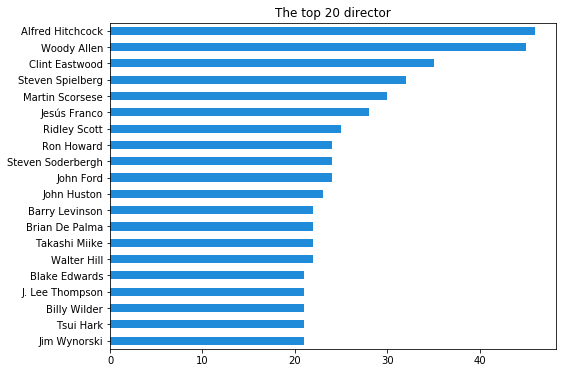

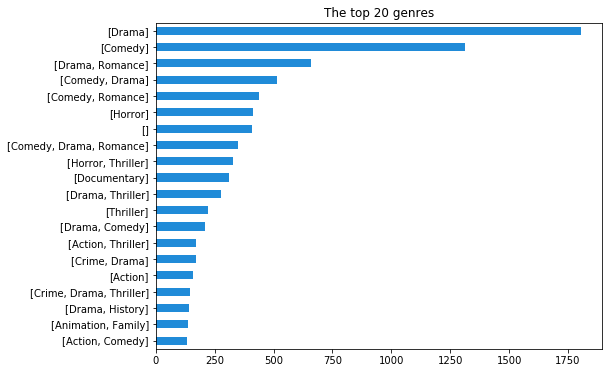

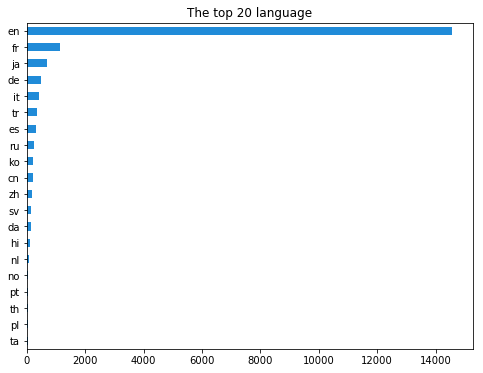

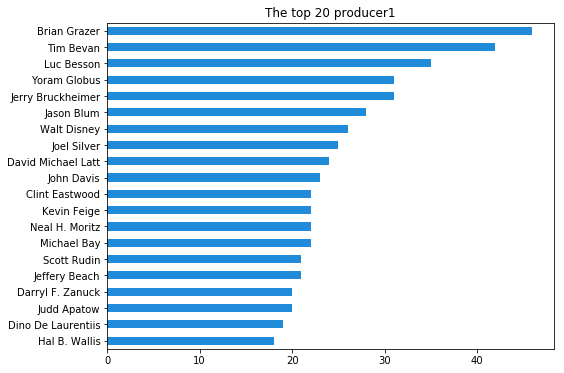

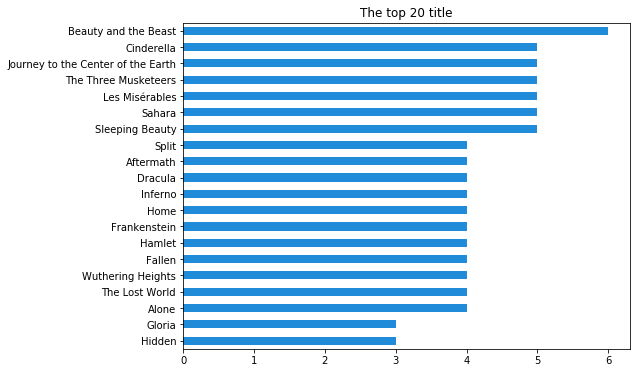

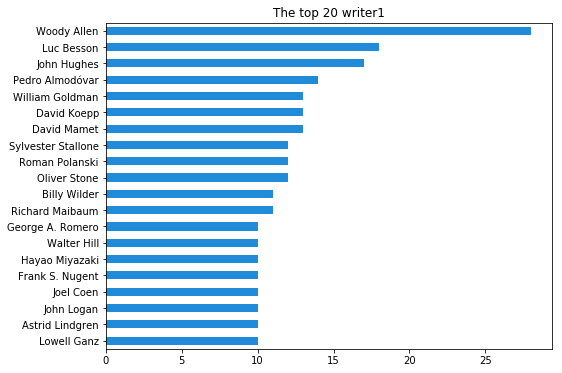

In [3]:
catlist = ['actor1', 'actor2', 'director', 'genres','language', 'producer1', 'title','writer1']

for category in catlist:
    fig, ax = plt.subplots()
    TMDB_all[category].value_counts().head(20).plot(ax=ax, kind='barh', figsize = (8,6), color="#208bd8", 
                                                    title="The top 20 " + str(category)).invert_yaxis()

### Distribution of numerical features

In [4]:
TMDB_all.describe()

,budget,revenue,runtime,tmdb_id
count,1.979900e+04,1.979900e+04,19603.000000,19799.000000
mean,9.233420e+06,2.428515e+07,98.575677,99421.218294
std,2.647418e+07,9.325235e+07,34.061956,126185.308710
min,0.000000e+00,0.000000e+00,0.000000,2.000000
25%,0.000000e+00,0.000000e+00,89.000000,13052.000000
50%,0.000000e+00,0.000000e+00,98.000000,36758.000000
75%,4.500000e+06,2.049322e+06,111.000000,142713.500000
max,1.000000e+09,2.781506e+09,877.000000,452472.000000


In [3]:
TMDB_all['release_year'] = pd.to_numeric(TMDB_all['release_date'].str[:4])

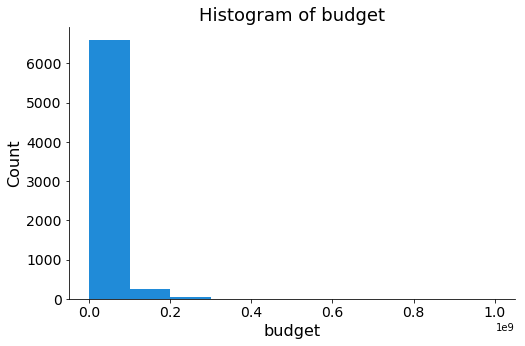

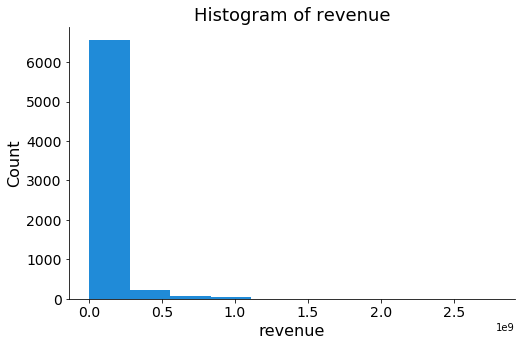

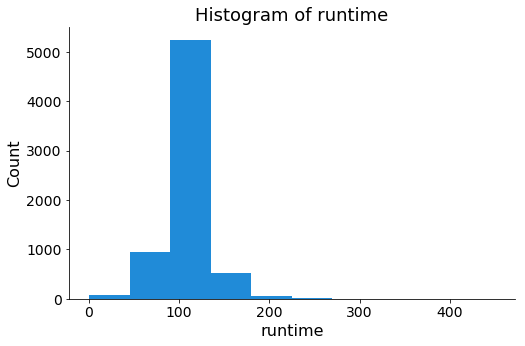

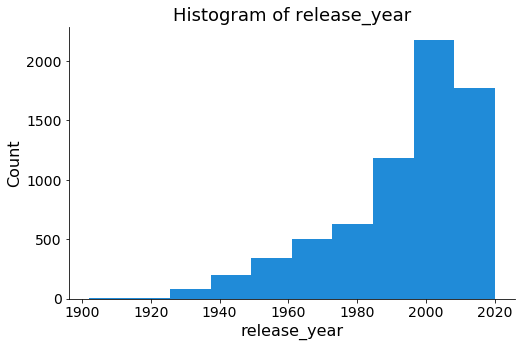

In [5]:
numlist = ['budget', 'revenue', 'runtime', 'release_year']

for variable in numlist:
    plt.figure(figsize=(8, 5))

    ax = plt.subplot(111)  
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)  
  
    ax.get_xaxis().tick_bottom()  
    ax.get_yaxis().tick_left()  
    ax.set_title("Histogram of " +str(variable), fontsize=18)

    plt.xticks(fontsize=14)  
    plt.yticks(fontsize=14)  

    plt.xlabel(str(variable), fontsize=16)  
    plt.ylabel("Count", fontsize=16)  
    
    df = TMDB_all.dropna()
    plt.hist(df[variable], color="#208bd8", bins=10)  
    plt.show();   

### Distributions over time

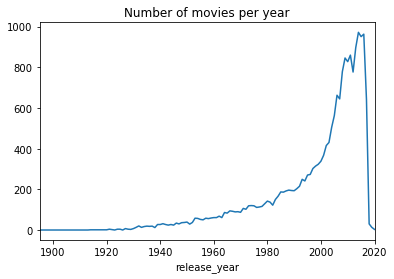

In [6]:
TMDB_all.groupby(['release_year']).agg(['count']).iloc[:,6].plot(title = "Number of movies per year")

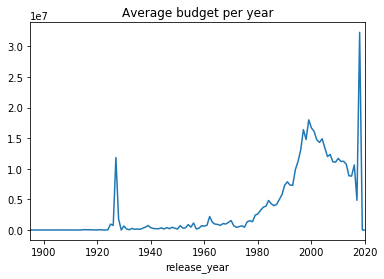

In [7]:
TMDB_all.groupby(['release_year']).agg(['mean']).iloc[:,1].plot(title = "Average budget per year")

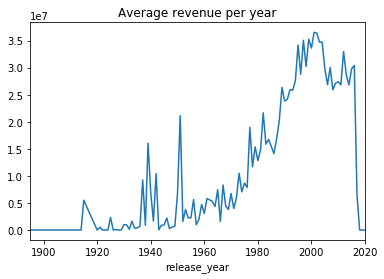

In [8]:
TMDB_all.groupby(['release_year']).agg(['mean']).iloc[:,2].plot(title = "Average revenue per year")

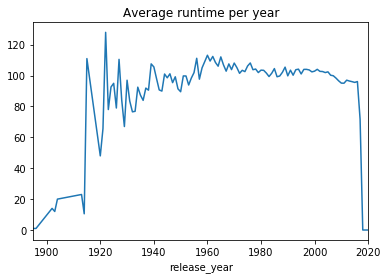

In [9]:
TMDB_all.groupby(['release_year']).agg(['mean']).iloc[:,3].plot(title = "Average runtime per year")

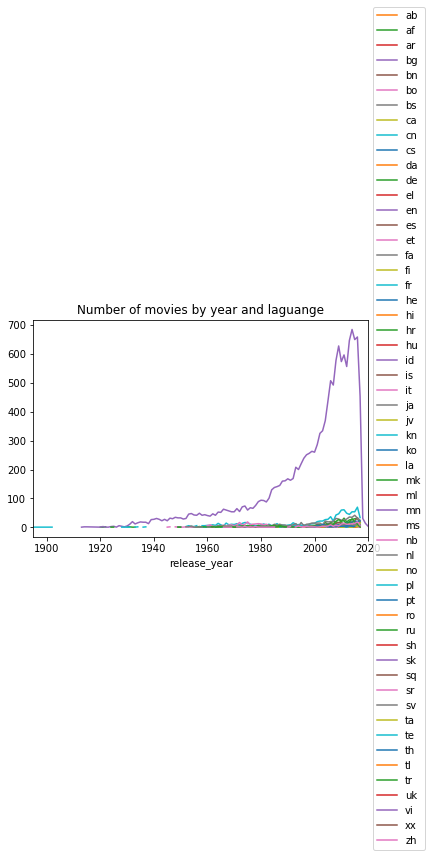

In [10]:

pd.pivot_table(TMDB_all, index=['release_year'], columns = 'language', 
                                 values = "release_date", aggfunc ='count')\
    .plot(title= "Number of movies by year and laguange").legend(loc='center left', bbox_to_anchor=(1, 0.5))

## Analyse the genres in the TMDB dataset


Use one-hot encoding on the genres. This will make plotting easier.

In [4]:
# need to first create string from the list of genres for this to work
tmdb_onehot = TMDB_all.copy()
tmdb_onehot['genres'] = tmdb_onehot['genres'].apply(lambda x: ', '.join(x))

# This should use tmdb.get_genres()
GENRE_LIST = [
    'Action', 'Adventure', 'Animation', 'Comedy', 'Crime',
    'Documentary', 'Drama', 'Family', 'Fantasy', 'History',
    'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction',
    'TV Movie', 'Thriller', 'War', 'Western'
]

for i, genr in enumerate(GENRE_LIST):
    tmdb_onehot[genr] =  tmdb_onehot['genres'].str.contains(genr)*1                 

tmdb_onehot.head(2)

,actor1,actor2,adult,budget,director,genres,imdb_id,keywords,language,overview,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,Alec Baldwin,Miles Bakshi,False,125000000,Tom McGrath,"Animation, Comedy, Family",tt3874544,"baby,family relationships,sibling rivalry,unre...",en,A story about how a new baby's arrival impacts...,...,0,0,0,0,0,0,0,0,0,0
1,Emma Watson,Dan Stevens,False,160000000,Bill Condon,"Fantasy, Music, Romance",tt2771200,"france,magic,castle,fairy tale,musical,curse,c...",en,A live-action adaptation of Disney's version o...,...,0,0,1,0,1,0,0,0,0,0


In [12]:
print tmdb_onehot.describe()

             budget       revenue       runtime        tmdb_id  release_year  \
count  1.979900e+04  1.979900e+04  19603.000000   19799.000000  19771.000000   
mean   9.233420e+06  2.428515e+07     98.575677   99421.218294   1998.693490   
std    2.647418e+07  9.325235e+07     34.061956  126185.308710     18.404372   
min    0.000000e+00  0.000000e+00      0.000000       2.000000   1895.000000   
25%    0.000000e+00  0.000000e+00     89.000000   13052.000000   1991.000000   
50%    0.000000e+00  0.000000e+00     98.000000   36758.000000   2006.000000   
75%    4.500000e+06  2.049322e+06    111.000000  142713.500000   2012.000000   
max    1.000000e+09  2.781506e+09    877.000000  452472.000000   2020.000000   

             Action     Adventure     Animation        Comedy         Crime  \
count  19799.000000  19799.000000  19799.000000  19799.000000  19799.000000   
mean       0.215971      0.126320      0.068286      0.314107      0.117986   
std        0.411504      0.332217      0.2

Show frequency of each genre within the TMDB dataset

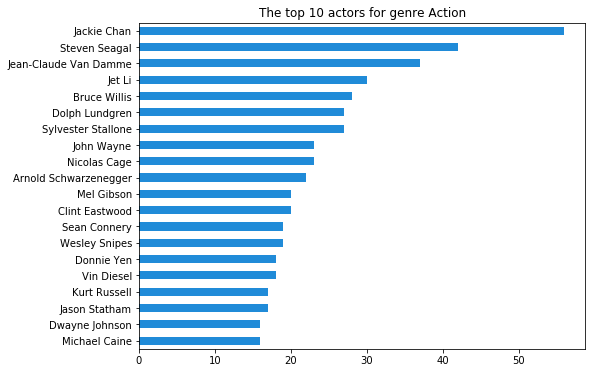

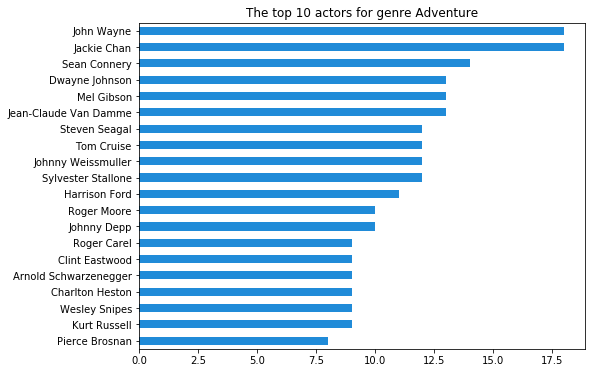

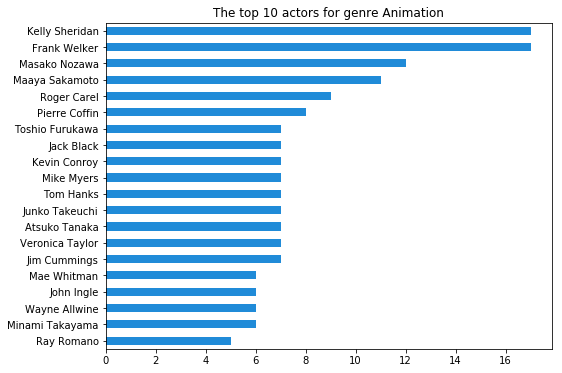

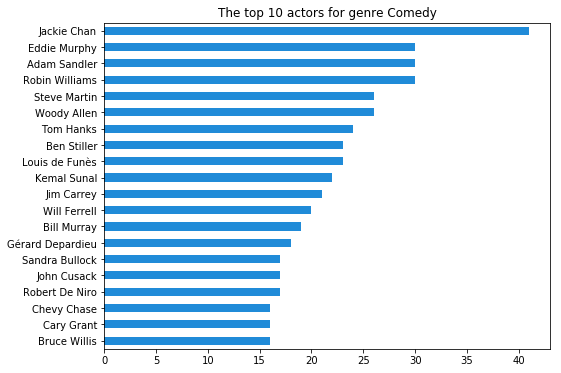

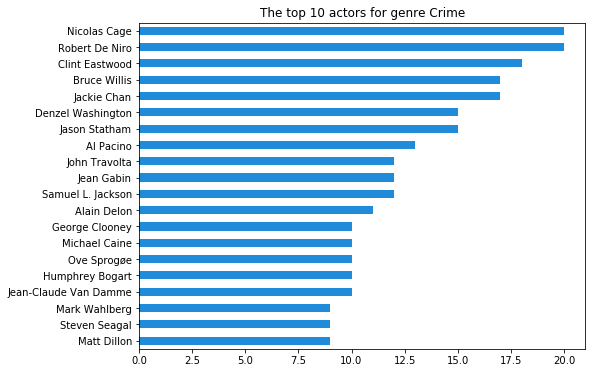

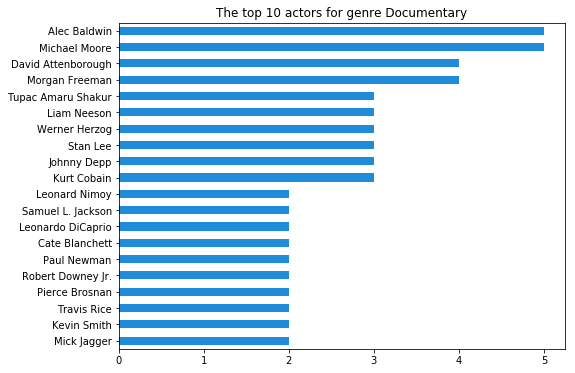

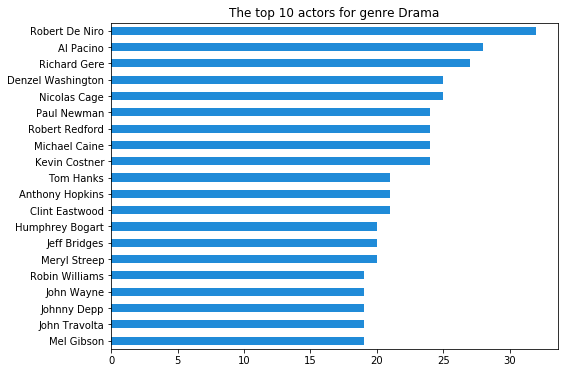

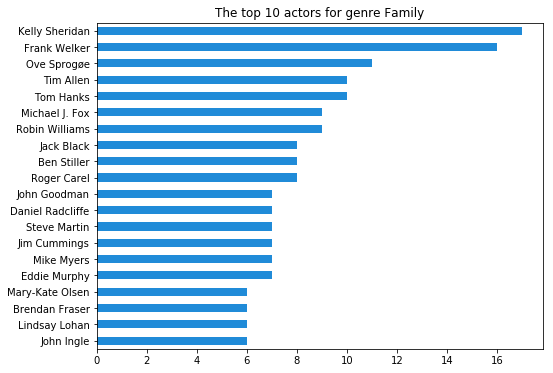

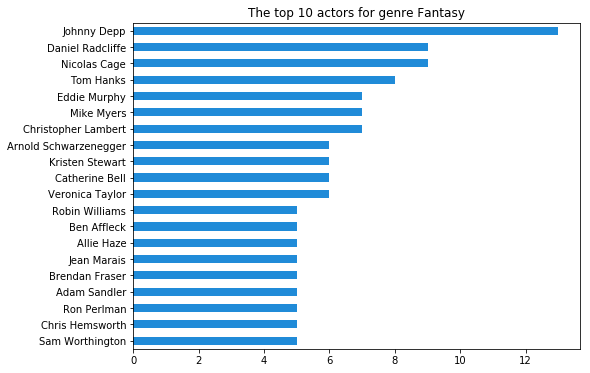

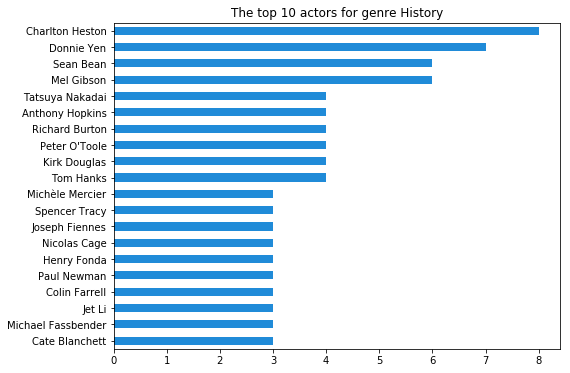

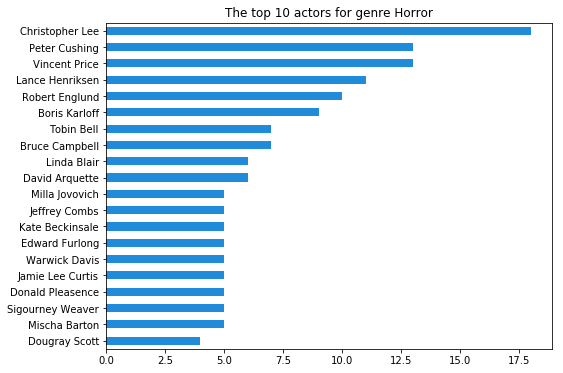

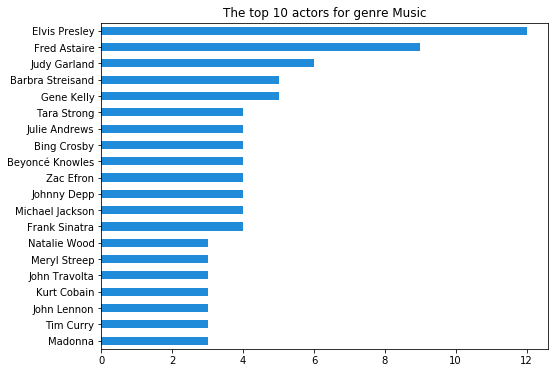

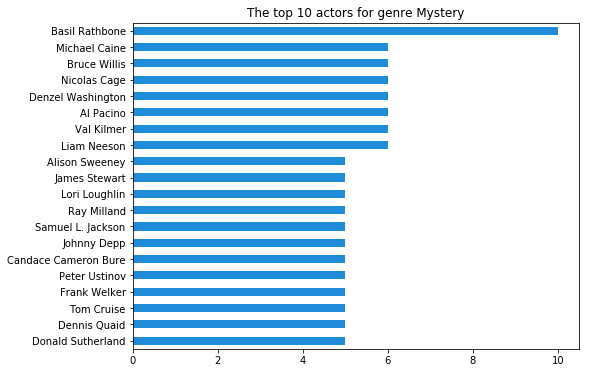

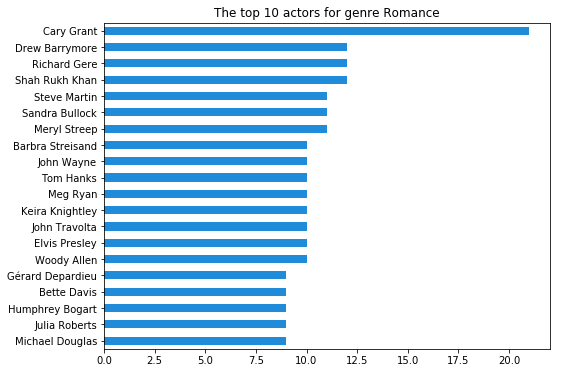

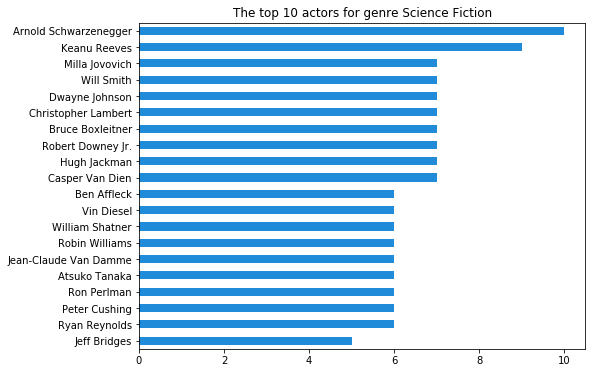

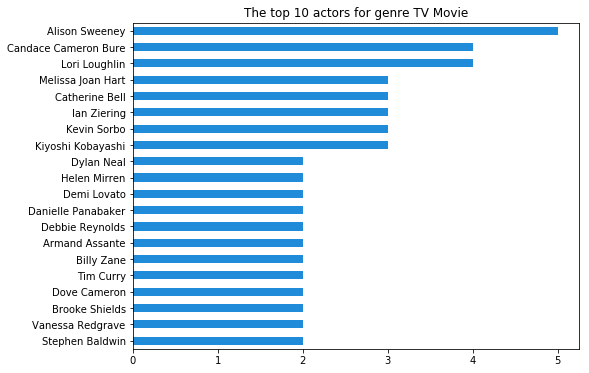

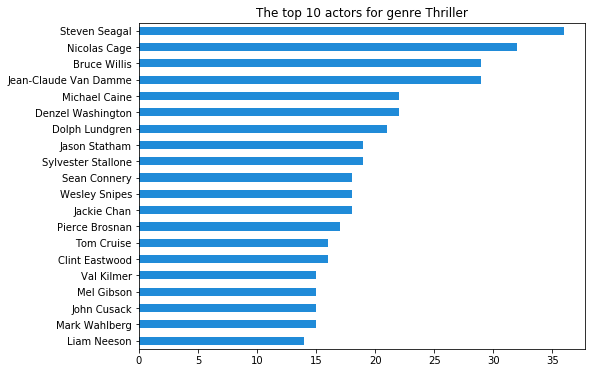

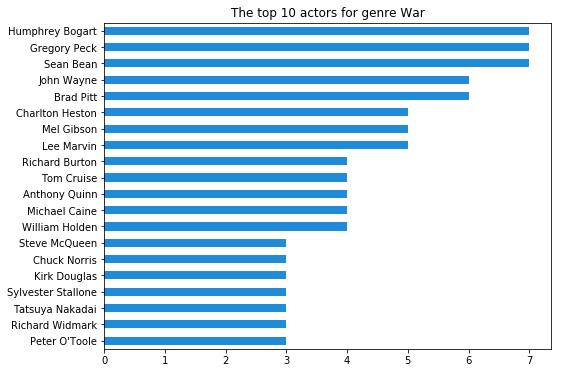

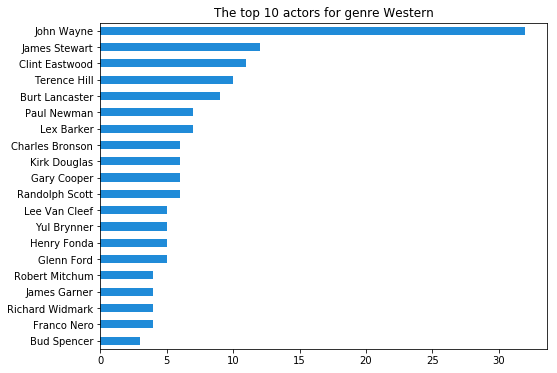

In [13]:
for genre in GENRE_LIST:
    fig, ax = plt.subplots()
    tmdb_onehot[tmdb_onehot[genre]==1]['actor1'].value_counts().head(20).plot(ax=ax, kind='barh', figsize = (8,6), color="#208bd8", 
                                                      title="The top 10 actors for genre " + str(genre)).invert_yaxis()

Show runtime versus genre


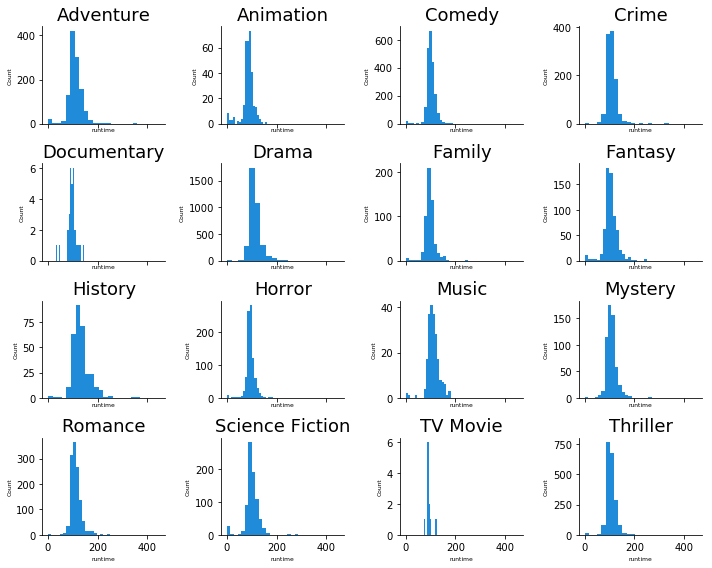

In [14]:
fig, axes = plt.subplots(nrows=4, ncols=4, sharey=False, sharex = True,figsize=(10,8))

for i, ax in enumerate(axes.flat, start=1):
 
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)  
  
    ax.get_xaxis().tick_bottom()  
    ax.get_yaxis().tick_left()  
    ax.set_title(str(GENRE_LIST[i]), fontsize=18)

    ax.set_xlabel(str("runtime"), fontsize=6)  
    ax.set_ylabel("Count", fontsize=6)  
    
    df = tmdb_onehot[tmdb_onehot[GENRE_LIST[i]]==1].dropna()
    ax.hist(df.runtime, color="#208bd8", bins=20)  


fig.tight_layout()

plt.show()

Show most frequent actors per genre

In [5]:
tmdb_onehot\
    .iloc[:, tmdb_onehot.columns.get_loc("Action"):tmdb_onehot.columns.get_loc("Western")+1]\
    .sum()

Action             4276
Adventure          2501
Animation          1352
Comedy             6219
Crime              2336
Documentary         521
Drama              9242
Family             1772
Fantasy            1508
History             737
Horror             2429
Music               588
Mystery            1312
Romance            3293
Science Fiction    1858
TV Movie            306
Thriller           4614
War                 604
Western             401
dtype: int64

Show frequency of top genre combinations

(below plot is actually the same as bar chart above, can delete one)

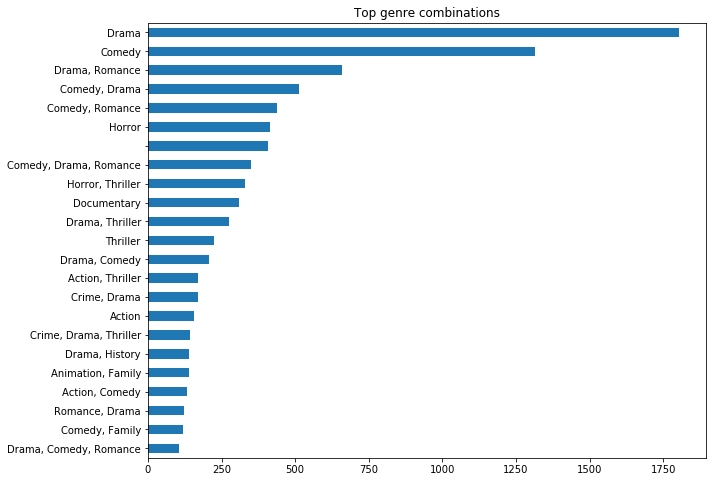

In [16]:
fig, ax = plt.subplots()
tmdb_onehot['genres'].value_counts()[tmdb_onehot['genres'].value_counts()>100].plot(ax=ax, kind='barh', figsize = (10,8), title="Top genre combinations").invert_yaxis()

Show frequency of those genre combinations over time

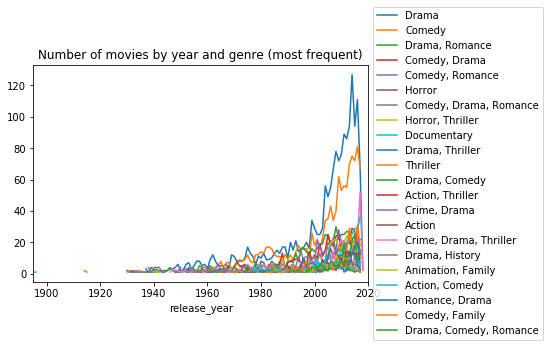

In [17]:
most_freq_gen_comb = tmdb_onehot['genres'].value_counts()[tmdb_onehot['genres'].value_counts()>100].index
pd.pivot_table(tmdb_onehot, index=['release_year'],
               columns = 'genres', values = "release_date",
               aggfunc ='count')[most_freq_gen_comb]\
    .plot(title= "Number of movies by year and genre (most frequent)")\
    .legend(loc='center left', bbox_to_anchor=(1, 0.5))

Show frequency of each of the genre pairs (including genre triples quadurples. Currently a movie with more than 2 genres is counted more than once!

In [8]:
tmdb_genre_pair = tmdb_onehot.copy()

tmdb_genre_pair["genres_nr"] =\
    tmdb_genre_pair.iloc[:,tmdb_genre_pair.columns.get_loc("Action"):tmdb_genre_pair.columns.get_loc("Western")+1]\
    .sum(axis = 1)
tmdb_genre_pair['single_genre'] = np.where(tmdb_genre_pair["genres_nr"] == 1, 1, 0)

for genre_pair in list(it.permutations(GENRE_LIST, 2)):
    tmdb_genre_pair['_'.join(genre_pair)] = \
        tmdb_genre_pair['genres'].str.contains(', '.join(genre_pair), regex = False)
        
# Now take care of those that only have 1 genre! create Drama_Drama...    
for genre in GENRE_LIST:
    tmdb_genre_pair[str(genre)+"_"+str(genre)] = tmdb_genre_pair[genre]*tmdb_genre_pair.single_genre

In [9]:
tmdb_genre_pair.head(2)

,actor1,actor2,adult,budget,director,genres,imdb_id,keywords,language,overview,...,History_History,Horror_Horror,Music_Music,Mystery_Mystery,Romance_Romance,Science Fiction_Science Fiction,TV Movie_TV Movie,Thriller_Thriller,War_War,Western_Western
0,Alec Baldwin,Miles Bakshi,False,125000000,Tom McGrath,"Animation, Comedy, Family",tt3874544,"baby,family relationships,sibling rivalry,unre...",en,A story about how a new baby's arrival impacts...,...,0,0,0,0,0,0,0,0,0,0
1,Emma Watson,Dan Stevens,False,160000000,Bill Condon,"Fantasy, Music, Romance",tt2771200,"france,magic,castle,fairy tale,musical,curse,c...",en,A live-action adaptation of Disney's version o...,...,0,0,0,0,0,0,0,0,0,0


In [10]:
pairs_sum = pd.DataFrame(
    tmdb_genre_pair.iloc[:,tmdb_genre_pair.columns.get_loc("Action_Adventure"):tmdb_genre_pair.columns.get_loc("Western_Western")+1].sum(),
    columns={"count"})

# Shot the top, non-zero, combinations.
pairs_sum[pairs_sum["count"] > 0].sort_values(by=['count'], ascending=[0])

,count
Drama_Drama,1842.0
Drama_Romance,1353.0
Comedy_Comedy,1329.0
Comedy_Drama,1312.0
Drama_Thriller,974.0
Action_Adventure,915.0
Crime_Drama,875.0
Comedy_Romance,703.0
Horror_Thriller,653.0
Action_Thriller,595.0


In [11]:
pairs_sum['pair'] = pairs_sum.index.str.replace("_",", ")

#print pairs_sum
pairs_sum.to_csv('pairs_sum.csv', sep=',',index=False)


## Chord plot for the genres
We built a dynamic chord plot for the genres out the movie genres. The plot can't be embedded in the notebook, but it's available here: https://tolkv.github.io/cs109beuteam/chord-chart_train.html

## Top genre pairs

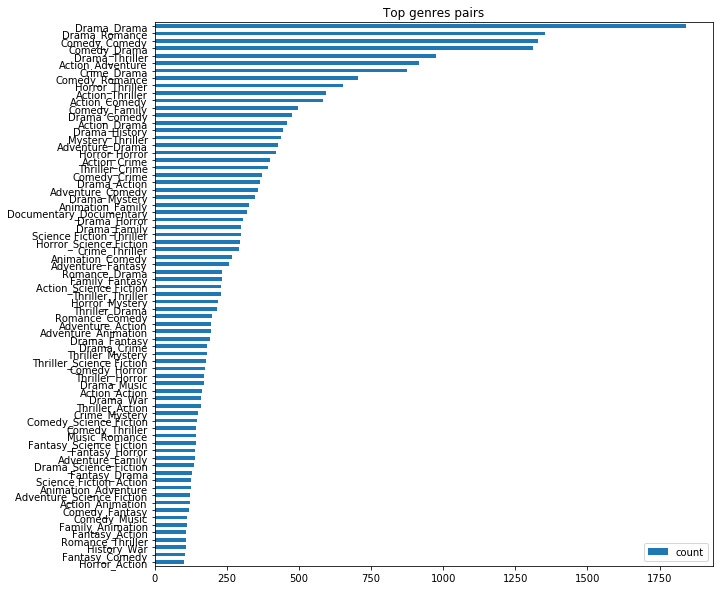

In [12]:
fig, ax = plt.subplots()
pairs_sum[pairs_sum.iloc[:,0]>=100].sort_values(by=['count'], ascending=True)\
    .plot(ax=ax, kind='barh', figsize = (10,10), title="Top genres pairs");

In [13]:
tmdb_onehot["genres_nr"] = tmdb_onehot.iloc[:,tmdb_onehot.columns.get_loc("Action"):tmdb_onehot.columns.get_loc("Western")+1].sum(axis =1)

print "Combinations by combination size"
for i in range(max(tmdb_onehot["genres_nr"]) +1):
    print i, tmdb_onehot[tmdb_onehot.genres_nr==i].groupby(['genres']).agg(['count']).T.iloc[0,:],"---"

Combinations by combination size
0 genres
           357
Foreign      2
Name: (actor1, count), dtype: int64 ---
1 genres
Action                   154
Action, Foreign            8
Adventure                 63
Adventure, Foreign         1
Animation                 70
Comedy                  1313
Comedy, Foreign           16
Crime                     22
Documentary              274
Documentary, Foreign       7
Drama                   1797
Drama, Foreign            33
Family                    38
Family, Foreign            1
Fantasy                   27
Foreign, Documentary       1
Foreign, Drama             4
Foreign, Horror            2
Foreign, Thriller          3
History                   10
Horror                   405
Horror, Foreign            6
Music                     34
Mystery                   10
Romance                   52
Science Fiction           67
TV Movie                   2
Thriller                 223
Thriller, Foreign          3
War                       12
Western  

Overall frequencies of genre combinations

In [24]:
tmdb_onehot['genres'].value_counts()[tmdb_onehot['genres'].value_counts()>tmdb_onehot.shape[0]/100]/tmdb_onehot.shape[0]

Drama                     0.091166
Comedy                    0.066316
Drama, Romance            0.033285
Comedy, Drama             0.025910
Comedy, Romance           0.022072
Horror                    0.020860
                          0.020658
Comedy, Drama, Romance    0.017728
Horror, Thriller          0.016617
Documentary               0.015607
Drama, Thriller           0.013940
Thriller                  0.011263
Drama, Comedy             0.010556
Name: genres, dtype: float64

Frequency of each genre alone

In [25]:
tmdb_onehot\
    .iloc[:, tmdb_onehot.columns.get_loc("Action"):tmdb_onehot.columns.get_loc("Western")+1]\
    .sum()/tmdb_onehot.shape[0]

Action             0.215971
Adventure          0.126320
Animation          0.068286
Comedy             0.314107
Crime              0.117986
Documentary        0.026314
Drama              0.466791
Family             0.089499
Fantasy            0.076165
History            0.037224
Horror             0.122683
Music              0.029698
Mystery            0.066266
Romance            0.166322
Science Fiction    0.093843
TV Movie           0.015455
Thriller           0.233042
War                0.030507
Western            0.020254
dtype: float64

### Discussion about the imbalanced nature of the data and how you want to address it
During our preliminary analyses in Milestone 1 we found that some genres are highly represented in the data (Drama overall 47%, Drama alone 7.7%) while others are way less represented (Animation 7.2%, Western overall 2%) . We devised a few strategies to deal with this problem and we will pick one after testing them on the field by training the required models:

- Randomly re-sample the train to make sure that we don't miss infrequent genres in the training set (e.g. randomly pick 100 movies per category).
- Perform stratified sampling of the train set. This will allow us to get a train set with the same proportion of the different genres available in the full dataset (it's easily available through *sklearn* *StratifiedShuffleSplit*)
- Use class weights according to frequency (possible for example in SVM and ridge regression)

### What does your choice of Y look like?
Since the project objective is to detect the movie genre from the poster data, the Y needs to relate with the genre itself. As we found in Milestone 1, each movie can report more than one genre. To overcome this problem, since genres are not mutually exclusive, we will use multi-label classification based on multiple classifiers.

The Y variable will have the value of 1 for movies that report the genre for which the model is being trained and 0 otherwise. We will combine the results from each trained model.

*Examples*

- Sample 1, genres [Comedy, Drama]
- Sample 2, genres [Horror, Biography]

When training the model for the “Comedy” genre, the Y variable for the samples will be:

- Sample 1: Y = 1
- Sample 2: Y = 0

When training the model for the “Drama” genre, the Y variable for the samples will be:

- Sample 1: Y = 1
- Sample 2: Y = 0

When training the model for the “Action” genre, the Y variable for the samples will be:

- Sample 1: Y = 0
- Sample 2: Y = 0

### Which features do you choose for X and why?
The features reported in the first answer are a subset of all the data we had available in the first milestone, coming from both TMDB and IMDB. We decided to retain only the data coming from TMDB, as there was no strong reason to keep IMDB data and TMDB has a nicer API. We also dropped the following attributes: assistant directors, full plot, imdb genres. The first one poorly correlate with the genre information and the other did not improve the information available too much compared to the effort of analysing it (e.g. full plot).

In the analyses we will process and use the keywords, overview and tagline fields with the bag of words approach.

We also decided to only keep the first two actors for each movie, since they were reported as the most important for that movie. A similar decision was taken for the writers, where we only keep the first writer.

### How do you sample your data, how many samples, and why?
To sample our data, we picked the 10.000 most popular movies reported by TMDB. The movie popularity is computed every day by TMDB considering the number of unique views each movie received on the website, the movie’s ratings, the number of times it was favoured and the number of times it was added to the watched list. A portion of the previous day score is also used to help trending movies.

In order to keep the size of the datasets manageable and to enable sharing it easily between all the team members, we decided to stop sampling at 10000 movies for the initial version of the dataset. This already gives us about 10Gb worth of data between movie metadata and movie posters.

We are working to grow the size of our dataset to 100.000 movies.
